 # Notebook 05: Train ANNs with PyTorch



 ### Primary Goal: Train and evaluate the artificial neural networks



 #### Background



 In the paper we start by training artificial neural networks, so we will do the same here in the notebooks using PyTorch.



 Note that the model used in the paper is included in the github repository, but we will also take you through the steps to build and train a similar network here.



 #### Step 1: Imports

In [2]:
!pip install gewitter-functions
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

#outlines for text
pe1 = [path_effects.withStroke(linewidth=1.5,
foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
foreground="w")]

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'

#one quick thing here, we need to set the random seed so we all get the same results no matter the computer or python session
_ = torch.manual_seed(43)


def param_summary(model: torch.nn.Module) -> None:
    """define our model description function again"""
    print(f"{'Layer Name':<20} {'Shape':<20} {'Param #':<10}")
    print("-" * 50)

    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<20} {str(list(param.shape)):<20} {param.numel():<10}")
            total_params += param.numel()

    print("-" * 50)
    print(f"{total_params=}")


 #### Step 2: Load data

In [4]:

#load training
try:
    df_t = pd.read_csv('../datasets/sub-sevir-engineered/lowres_features_train.csv')
except FileNotFoundError:
    df_t = pd.read_csv('https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part2/refs/heads/main/datasets/sub-sevir-engineered/lowres_features_train.csv')
#load validation set
try:
    df_v = pd.read_csv('../datasets/sub-sevir-engineered/lowres_features_val.csv')
except FileNotFoundError:
    df_v = pd.read_csv('https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part2/refs/heads/main/datasets/sub-sevir-engineered/lowres_features_val.csv')


#make matrices for training/validation
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,36]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,36]

# Convert to PyTorch Tensors (Float32 is standard for NNs)
X_t_tensor = torch.tensor(X_t, dtype=torch.float32)
y_t_tensor = torch.tensor(y_t, dtype=torch.float32).view(-1, 1) # Reshape to (N, 1)

X_v_tensor = torch.tensor(X_v, dtype=torch.float32)
y_v_tensor = torch.tensor(y_v, dtype=torch.float32).view(-1, 1)


 #### Step 3: Make PyTorch Dataset



 As we discussed in the previous notebook, we need to shuffle and batch the data. We will leverage `torch.utils.data.DataLoader`.

In [5]:
# make datasets
train_ds = TensorDataset(X_t_tensor, y_t_tensor)
val_ds = TensorDataset(X_v_tensor, y_v_tensor)

# batch size
batch_size = 32

# make dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)  # Shuffle only the training
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


 Just a few quick notes on batching: First, we technically do not need to batch the validation data if it fits in memory. The reason we do so here is to handle memory efficiently when computing predictions. Second, it is important to carefully choose how much data to include within a single batch. If your batch is too small, it could take many iterations to train the model. Conversely, a batch that is too large can overwhelm your RAM. As such, the optimal batch size will be machine dependent.

#### Step 4: Build a model

In the paper we note that neural networks do not have a "one size fits all" paradigm, where a set of default parameters can consistently achieve good results. With neural networks you *need* to do some sort of hyperparameter search. So here, while we only show one model configuration, we encourage you to play around with different model configurations to figure out what hyperparameters work best for a given prediction task. In fact, we have a modular script that leverages the tensorflow api to help optimize your model configurations. The notebook example explaining this script is [here](#) <-- dead link right now!

Let's start simple and create a model with 2 layers with 2 neurons each to classify whether or not an example contains lightning (0 no lightning, 1 lightning).

In [6]:
class SimpleANN(torch.nn.Module):
    "My first PyTorch Model"
    def __init__(self, X_t: torch.Tensor) -> None:
        """
        Instantiate model. Define all the layers the model will use

        Args:
            X_t: input tensor for model
        Returns:
            None
        """
        super(SimpleANN, self).__init__()

        self.linear1 = nn.Linear(in_features=X_t.shape[1], out_features=2)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=2, out_features=2)
        self.activation2 = nn.ReLU()
        self.output = nn.Linear(in_features=2, out_features=1)
        self.activation_output = nn.Sigmoid()

    def forward(self, x):
        """define forward pass for the model"""
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.output(x)
        x = self.activation_output(x)
        return x


model = SimpleANN(X_t=X_t)
print(model)
param_summary(model)

SimpleANN(
  (linear1): Linear(in_features=36, out_features=2, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=2, out_features=2, bias=True)
  (activation2): ReLU()
  (output): Linear(in_features=2, out_features=1, bias=True)
  (activation_output): Sigmoid()
)
Layer Name           Shape                Param #   
--------------------------------------------------
linear1.weight       [2, 36]              72        
linear1.bias         [2]                  2         
linear2.weight       [2, 2]               4         
linear2.bias         [2]                  2         
output.weight        [1, 2]               2         
output.bias          [1]                  1         
--------------------------------------------------
total_params=83


 Notice the following about the above definition of the model:



 1. The input layer *always* has the `in_features` defined

    - This is needed so that the model is initialized with the correct number of weights.



 2. The activation functions for the input and hidden layers are `ReLU`

    - NNs require an activation function to effectively learn non-linear relationships in the data.  The 'relu' activation function is commonly used for this purpose.



 3. The output layer (last layer) has a *sigmoid* activation function

    - This is specifically for classification tasks. If we were training a regression model (as in the previous notebook), we wouldn't need this (i.e., linear activation).
    - If you have more than one output neuron (say if you have more than two possible classifications such as 'no lightning', 'some lightning', and 'lots of lightning'), then you would use *softmax* instead of sigmoid.




 #### Step 5: Run some data through it



 In order to visualize the initial performance with random weights and biases, we can plug the data into the untrained model. Unlike Keras, we need to manually pass the data through the model, preferably using `no_grad` to save memory.

(0.0, 1.0)

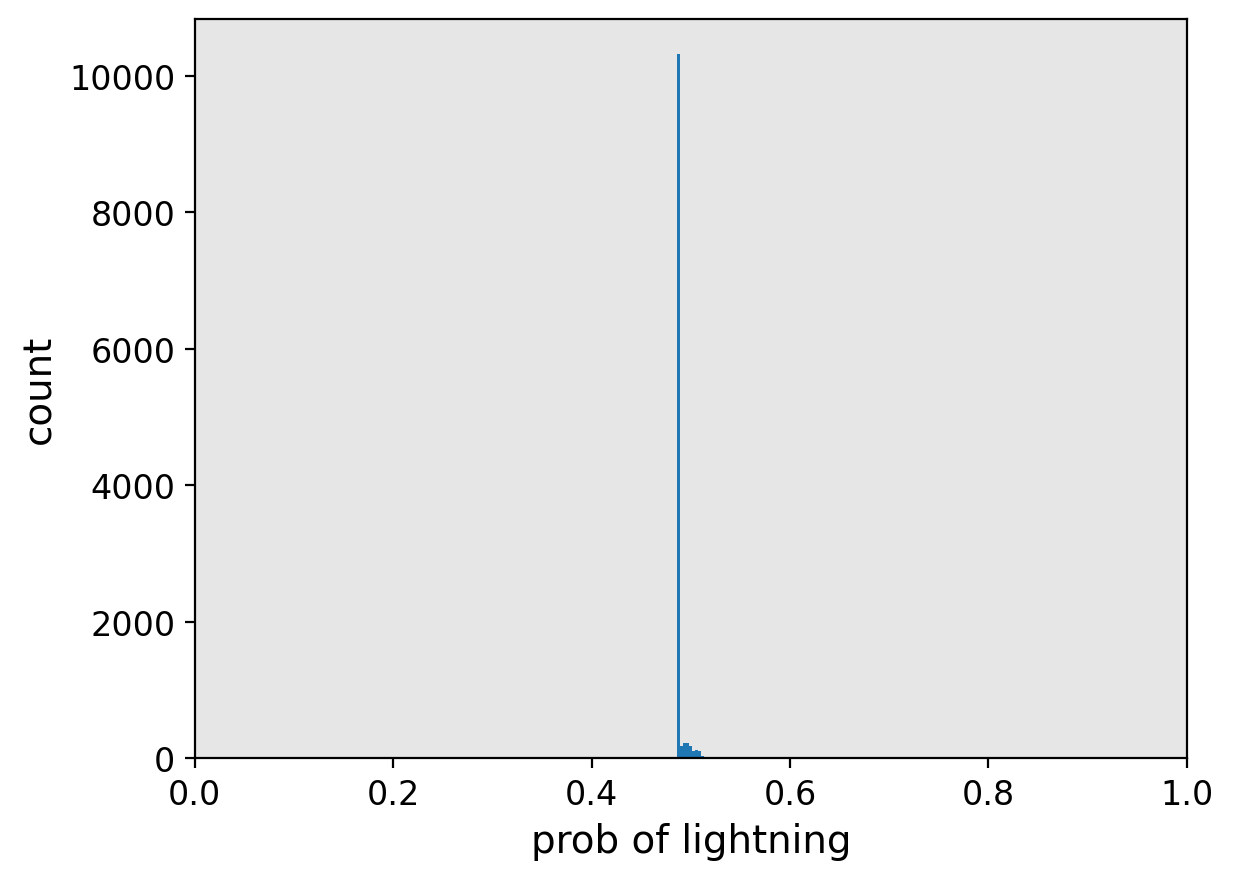

In [7]:
# Set model to evaluation mode
model.eval()

# Get predictions for the validation set
with torch.no_grad():
    # We can pass the whole tensor since it fits in memory,
    # or iterate the loader if it was huge. Let's pass the tensor.
    y_preds_tensor = model(X_v_tensor)
    y_preds = y_preds_tensor.numpy() # Convert back to numpy for plotting

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 The sigmoid function in the output layer ensures that all model output falls between 0 - 1. In order to plot the performance diagram, we need to calculate TP, FP, and FN. We will define a helper function for this using Numpy.

In [8]:
import torch
import numpy as np
from torchmetrics.classification import StatScores


class MultiThresholdMetrics:
    """Calculate classification metrics for range of thresholds"""
    def __init__(self, thresholds: torch.Tensor, device='cpu'):
        self.thresholds = thresholds.to(device).view(1, -1) # Shape: (1, n_thresholds)
        self.device = device

    def __call__(self, y_true, y_pred) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        y_true: (N,) or (N, 1) - Ground truth labels (0 or 1)
        y_pred: (N,) or (N, 1) - Predicted probabilities
        """
        # Ensure inputs are flat and on the correct device
        y_true = y_true.to(self.device).view(-1, 1) # Shape: (N, 1)
        y_pred = y_pred.to(self.device).view(-1, 1) # Shape: (N, 1)

        # Broadcast comparison: (N, 1) >= (1, T) -> (N, T)
        # This creates a boolean matrix where each column corresponds to a threshold
        pred_labels = (y_pred >= self.thresholds).float()

        # Calculate Stats per threshold (summing over the batch dimension N)
        # True Positives: Predicted 1 AND Actual 1
        tps = (pred_labels * y_true).sum(dim=0)

        # False Positives: Predicted 1 AND Actual 0
        fps = (pred_labels * (1 - y_true)).sum(dim=0)

        # False Negatives: Predicted 0 AND Actual 1
        fns = ((1 - pred_labels) * y_true).sum(dim=0)

        return tps, fps, fns


# Instantiate
thresh = torch.tensor(np.arange(0.05, 1.05, 0.05), dtype=torch.float32)
metric_calculator = MultiThresholdMetrics(thresh)

# Calculate
tps, fps, fns = metric_calculator(torch.Tensor(y_v), y_preds_tensor)
tps, fps, fns = [x.numpy() for x in (tps, fps, fns)]

# Note: adding epsilon to avoid division by zero
eps = 1e-7
pods = tps / (tps + fns + eps)       # Probability of Detection (Recall)
srs = tps / (tps + fps + eps)        # Success Ratio (Precision)
csis = tps / (tps + fns + fps + eps) # Critical Success Index

print("PODs:", pods)
print("SRs:", srs)
print("CSIs:", csis)

PODs: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.07397047 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
SRs: [0.55825454 0.55825454 0.55825454 0.55825454 0.55825454 0.55825454
 0.55825454 0.55825454 0.55825454 0.9979036  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
CSIs: [0.55825454 0.55825454 0.55825454 0.55825454 0.55825454 0.55825454
 0.55825454 0.55825454 0.55825454 0.07395898 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


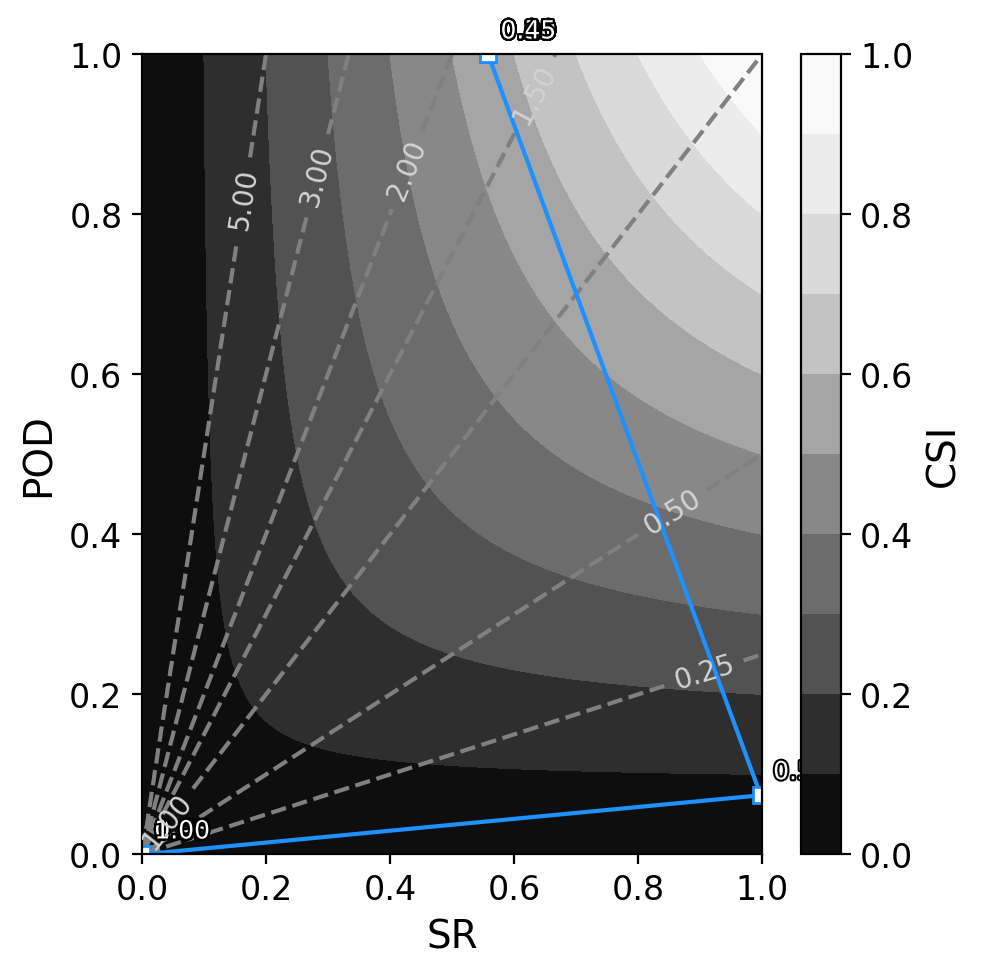

In [9]:
# import some helper functions for our other directory.
# import sys
# sys.path.insert(1, '../scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table, make_performance_diagram_axis, get_acc, get_pod, get_sr, csi_from_sr_and_pod

#plot it up
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh.numpy()):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i] + 0.02, np.asarray(pods)[i] + 0.02,
        text,
        path_effects=pe1,
        fontsize=9,
        color='white'
    )

plt.tight_layout()


As expected, the model performance looks wonky\! It is an untrained model.

#### Step 6: Train the model

Okay, let's
1. define our loss and optimizer,
2. and then write the training loop.

We will use **Binary Cross Entropy** (`BCELoss`) and Root **Mean Square Propagation** (`RMSprop`).

In [10]:
# Define Loss and Optimizer
loss_fn = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

# Lists to keep track of losses
train_losses = []
val_losses = []

epochs = 25
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass
        preds = model(x_batch)

        # 3. Calculate loss
        loss = loss_fn(preds, y_batch)

        # 4. Backward pass
        loss.backward()

        # 5. Step
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    epoch_train_loss = running_loss / len(train_ds)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            val_preds = model(x_val)
            v_loss = loss_fn(val_preds, y_val)
            running_val_loss += v_loss.item() * x_val.size(0)

    epoch_val_loss = running_val_loss / len(val_ds)
    val_losses.append(epoch_val_loss)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")


Epoch 5/25 | Train Loss: 0.2473 | Val Loss: 0.2621
Epoch 10/25 | Train Loss: 0.2431 | Val Loss: 0.2579
Epoch 15/25 | Train Loss: 0.2411 | Val Loss: 0.2541
Epoch 20/25 | Train Loss: 0.2401 | Val Loss: 0.2560
Epoch 25/25 | Train Loss: 0.2393 | Val Loss: 0.2558




 #### Step 7: Check for overfitting



 We manually tracked the losses in lists (`train_losses` and `val_losses`) during the loop. This data is very useful for determining if a model is overfitting. Let's plot the training loss vs the validation loss:

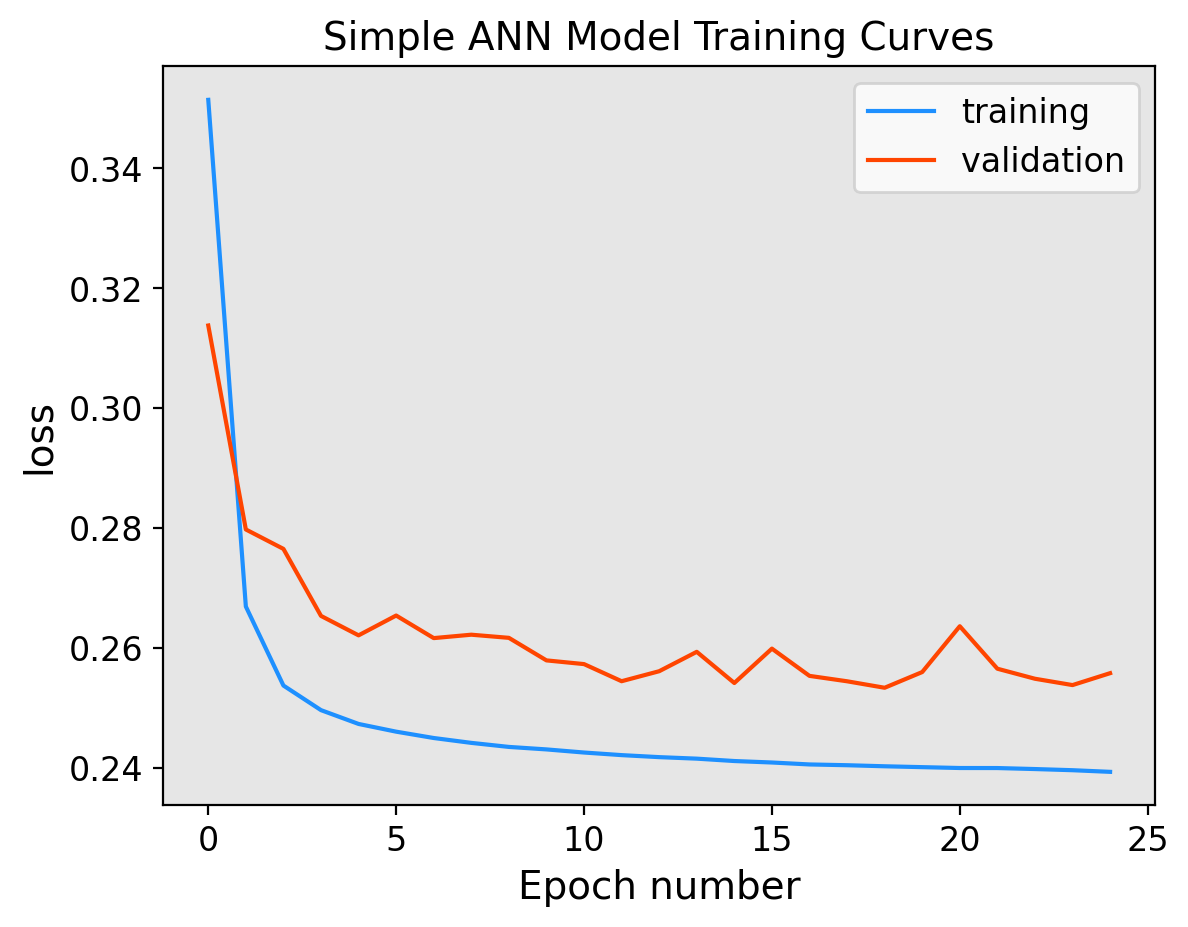

In [11]:
plt.plot(train_losses, color='dodgerblue', label='training')
plt.plot(val_losses, color='orangered', label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')
plt.title("Simple ANN Model Training Curves")
plt.show()

 Above, you want to compare the red line to the blue line. The absolute value is less important. Notice that the red line is relatively flat after about 10 epochs. This isn't much of an overfitting signal, which would be increasing validation loss with more epochs, but it does seem to have converged to some local minimum.



 #### Step 8: Check validation performance



 Now that the model is trained, let's check the new predictions and generate the performance diagram:

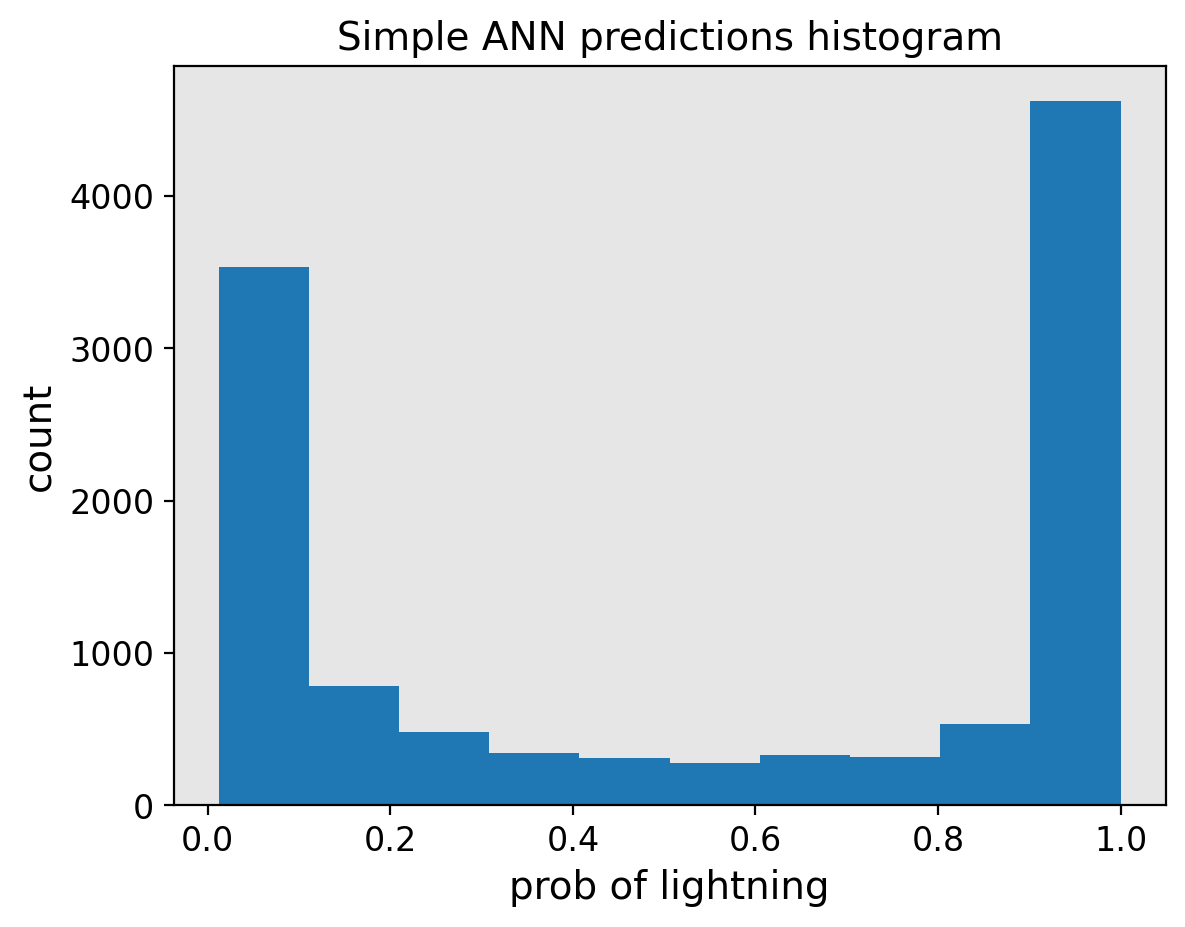

In [12]:
# Set model to eval mode
model.eval()
with torch.no_grad():
    y_preds_tensor = model(X_v_tensor)
    y_preds = y_preds_tensor.numpy()

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.title('Simple ANN predictions histogram')
plt.show()


 Well this looks better than before, and we can see that there is a good number of predictions near 1 (lightning) and 0 (no lightning). Hopefully these predictions align with the correct 'truth' labels. Let's take a look at the performance diagram.

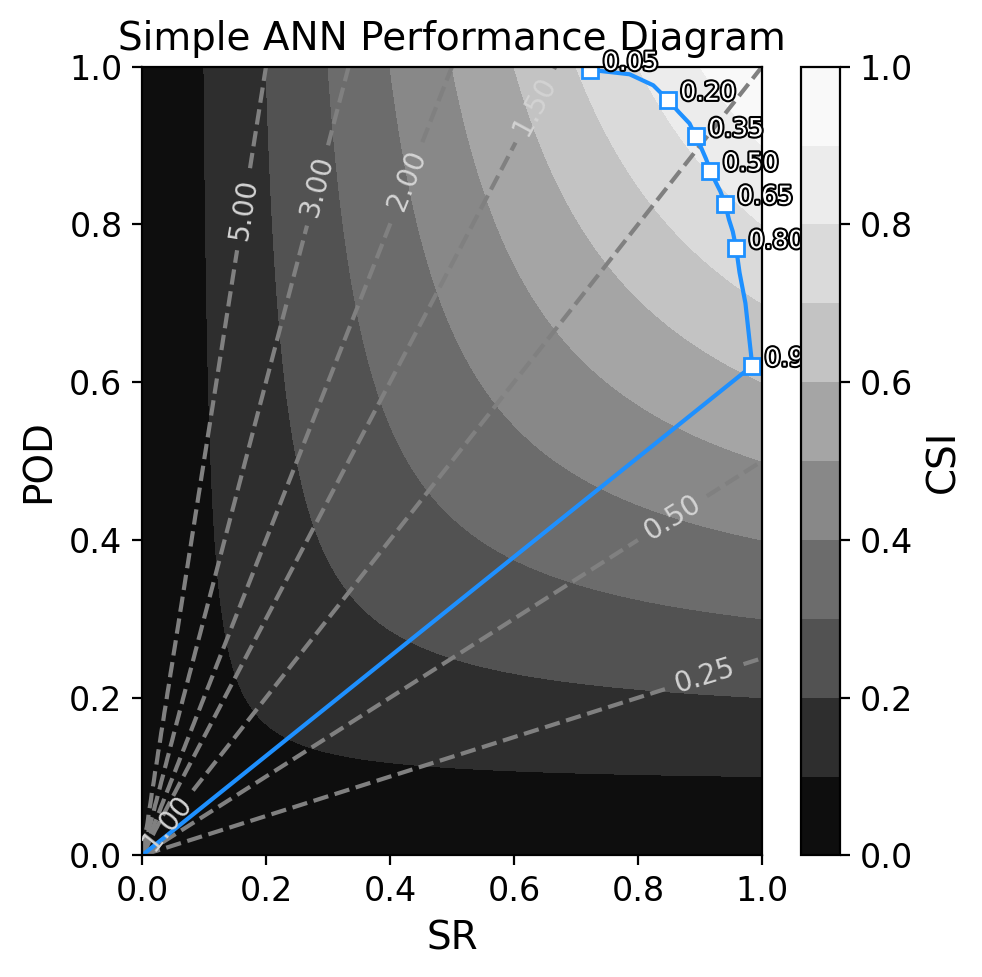

In [13]:
# Recalculate metrics with trained predictions
tps, fps, fns = metric_calculator(torch.Tensor(y_v), y_preds_tensor)
tps, fps, fns = [x.numpy() for x in [tps, fps, fns]]

#calc x,y of performance diagram
pods = tps/(tps + fns + eps)
srs = tps/(tps + fps + eps)
csis = tps/(tps + fns + eps)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs), np.asarray(pods), '-', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh.numpy()):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.plot(np.asarray(srs)[i], np.asarray(pods)[i], 's', color='dodgerblue', markerfacecolor='w')
        ax.text(np.asarray(srs)[i] + 0.02, np.asarray(pods)[i], text, path_effects=pe1, fontsize=9, color='white')

plt.title("Simple ANN Performance Diagram")
plt.tight_layout()


 MUCH BETTER. Even just a simple neural network does well here. This is probably because the task is relatively easy - remember that we could use a simple brightness temperature threshold for IR to get an 80% accuracy.



 Because this network is so small, we can actually view the learned weights and biases of each layer.

In [14]:
# Input layer weights
# note weights addressed by structure in model class definition
model.linear1.weight

Parameter containing:
tensor([[-0.0686, -0.0561,  0.4786,  0.0585,  0.0112, -0.2456, -0.1432,  0.0062,
         -0.1127, -0.0609, -0.3485, -0.4089, -0.2058,  0.2728,  0.5384,  0.0304,
          0.2171, -0.0169, -0.3080, -0.3383,  0.0565,  0.1653, -0.1681,  0.0223,
          0.0151,  0.1641, -0.0397, -1.0611, -0.8841, -0.9105, -0.4205, -0.5219,
          0.3427,  0.1625,  0.2122, -0.3440],
        [-1.1201, -0.8836, -0.7759, -0.3134,  0.1698,  0.3015,  0.2819,  0.0224,
          0.8008, -0.7026,  0.0978,  0.0128,  0.2520,  0.1295, -0.3638,  0.3439,
         -0.0139,  0.6457, -0.1316, -0.0915, -0.2134, -0.0790, -0.1850, -0.2424,
         -0.2406,  0.2984,  0.2714, -0.0441, -0.1093, -0.4574, -0.4232,  0.2149,
          0.0227,  0.3233,  0.0052,  0.1104]], requires_grad=True)

In [15]:
# First hidden layer weights
model.linear2.weight


Parameter containing:
tensor([[-0.8109,  0.5299],
        [ 0.1822, -0.2492]], requires_grad=True)

 #### Step 9: Save trained model



 Now that you have a model trained, you probably don't want to re-train it every time you need to make a prediction. In PyTorch, the standard is to save the `state_dict`, which is a dictionary containing all the learnable parameters.

In [16]:
model_path = '../datasets/models/neural_nets_from_notebooks/MyFirstNN.pt'
model_path = 'MyFirstNN.pt'
torch.save(model.state_dict(), model_path)


 This saves the trained parameters to a `.pt` file. This is the most robust way to save PyTorch models.



 #### Step 11: Load trained model



 To load the model, we first need to instantiate the model architecture (the code must be available), and then load the state dictionary into it.

In [17]:
# 1. Re-create the model architecture
loaded_model = SimpleANN(X_t=X_t)

# 2. Load the weights
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval() # Don't forget to set to eval mode!

SimpleANN(
  (linear1): Linear(in_features=36, out_features=2, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=2, out_features=2, bias=True)
  (activation2): ReLU()
  (output): Linear(in_features=2, out_features=1, bias=True)
  (activation_output): Sigmoid()
)

 #### Step 12: Run loaded model



 Now it's all set to run\!

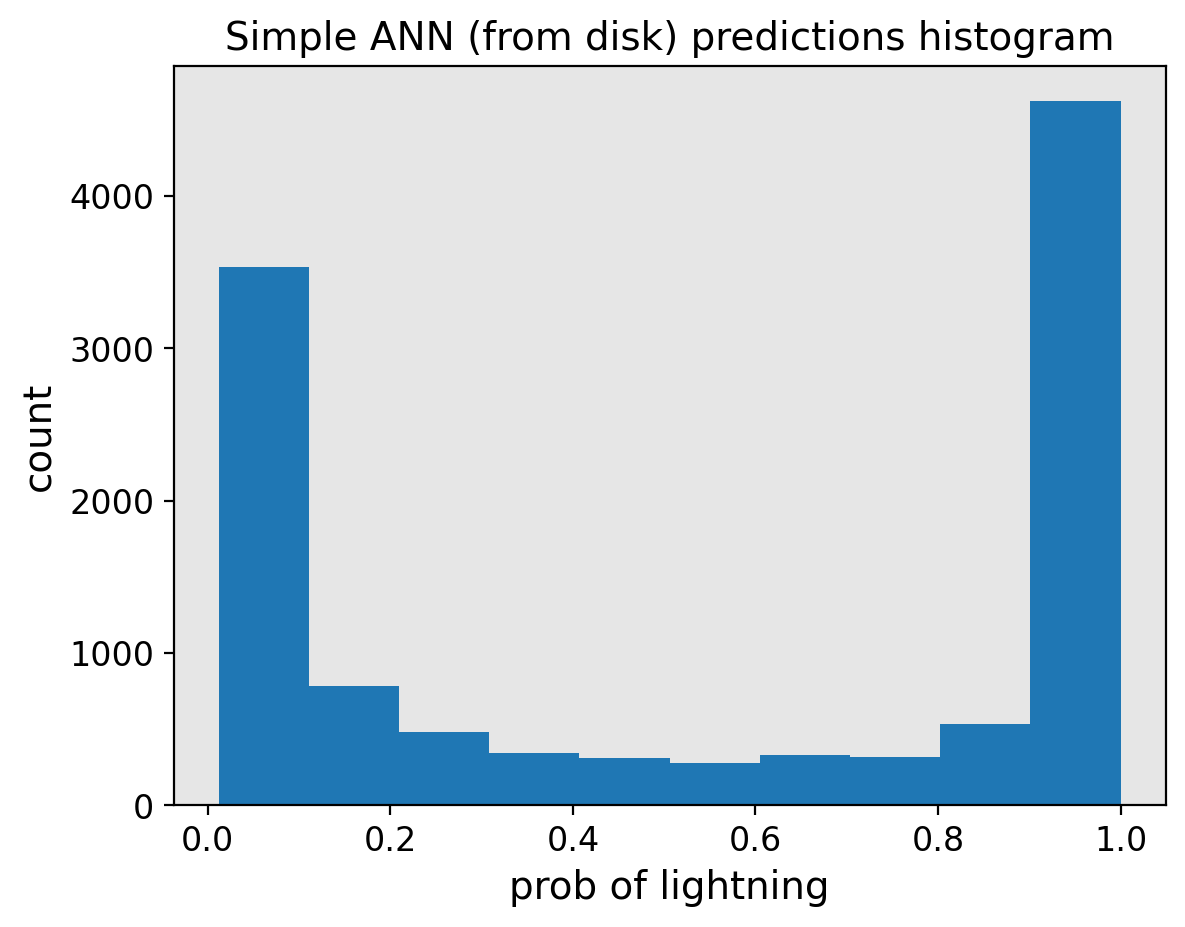

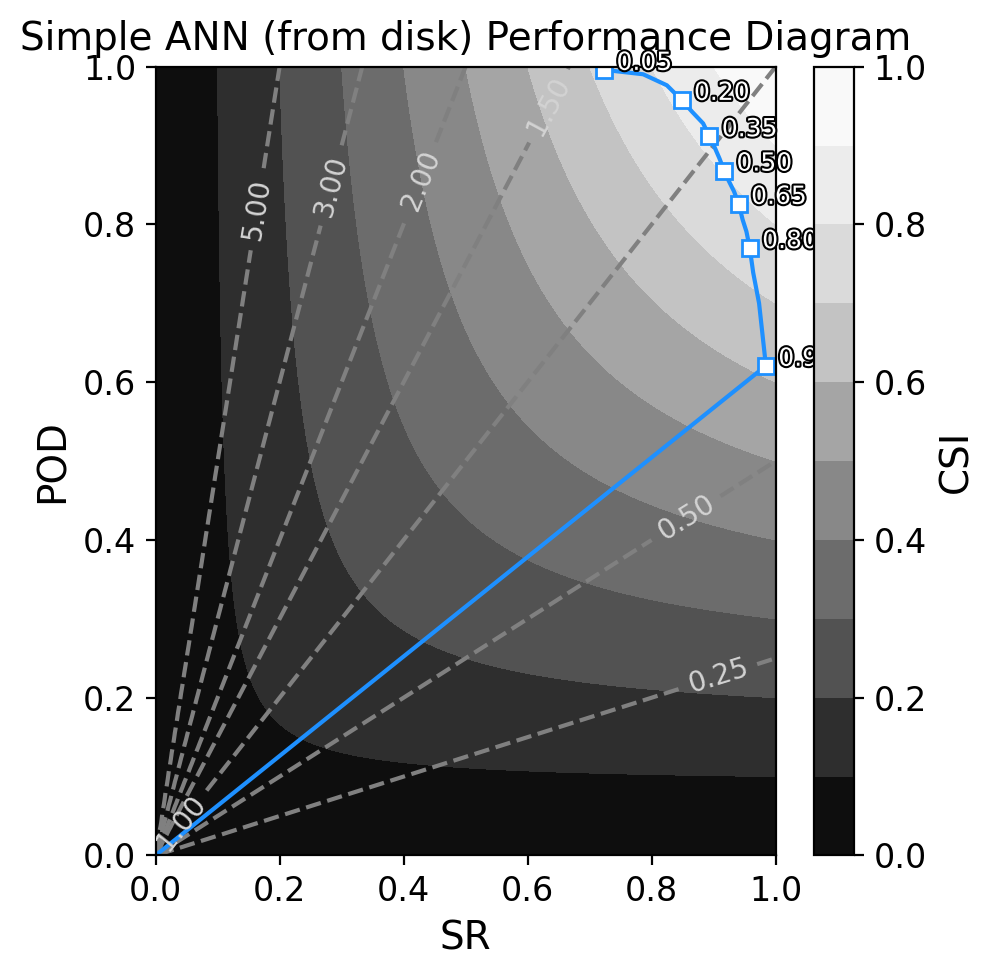

In [18]:
with torch.no_grad():
    y_preds_tensor = loaded_model(X_v_tensor)
    y_preds = y_preds_tensor.numpy()

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.title("Simple ANN (from disk) predictions histogram")
plt.show()

# Recalculate metrics
tps, fps, fns = metric_calculator(torch.Tensor(y_v), y_preds_tensor)

#calc x,y of performance diagram
pods = tps/(tps + fns + eps)
srs = tps/(tps + fps + eps)
csis = tps/(tps + fns + fps + eps)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs), np.asarray(pods), '-' , color='dodgerblue', markerfacecolor='w', label='UNET')

for i,t in enumerate(thresh.numpy()):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.plot(np.asarray(srs)[i], np.asarray(pods)[i], 's', color='dodgerblue', markerfacecolor='w')
        ax.text(np.asarray(srs)[i]+0.02, np.asarray(pods)[i], text, path_effects=pe1, fontsize=9, color='white')

plt.title("Simple ANN (from disk) Performance Diagram")
plt.tight_layout()


#### Step 13: Load and run a pre-trained network

Here we load a pre-trained model from disk. Note we're loading the entire model here. This ANN Classifier model was 'traced' into TorchScript - a ScriptFunction. This is a serialized deployable object representing the original as a static DAG.


In [ ]:
# load pretrained model
pretrained_model_path = "../datasets/models/neural_net_from_paper/sub-sevir-ann-class-1d-eng-TorchScript.pt"
pretrained_model = torch.jit.load(pretrained_model_path)
pretrained_model.eval()

RecursiveScriptModule(
  original_name=ANNClassificationPaperModel
  (linear1): RecursiveScriptModule(original_name=Linear)
  (activation1): RecursiveScriptModule(original_name=ReLU)
  (batchnorm1): RecursiveScriptModule(original_name=BatchNorm1d)
  (dropout1): RecursiveScriptModule(original_name=Dropout)
  (linear2): RecursiveScriptModule(original_name=Linear)
  (activation2): RecursiveScriptModule(original_name=ReLU)
  (batchnorm2): RecursiveScriptModule(original_name=BatchNorm1d)
  (dropout2): RecursiveScriptModule(original_name=Dropout)
  (linear3): RecursiveScriptModule(original_name=Linear)
  (activation3): RecursiveScriptModule(original_name=ReLU)
  (batchnorm3): RecursiveScriptModule(original_name=BatchNorm1d)
  (dropout3): RecursiveScriptModule(original_name=Dropout)
  (output): RecursiveScriptModule(original_name=Linear)
  (activation_output): RecursiveScriptModule(original_name=Sigmoid)
)

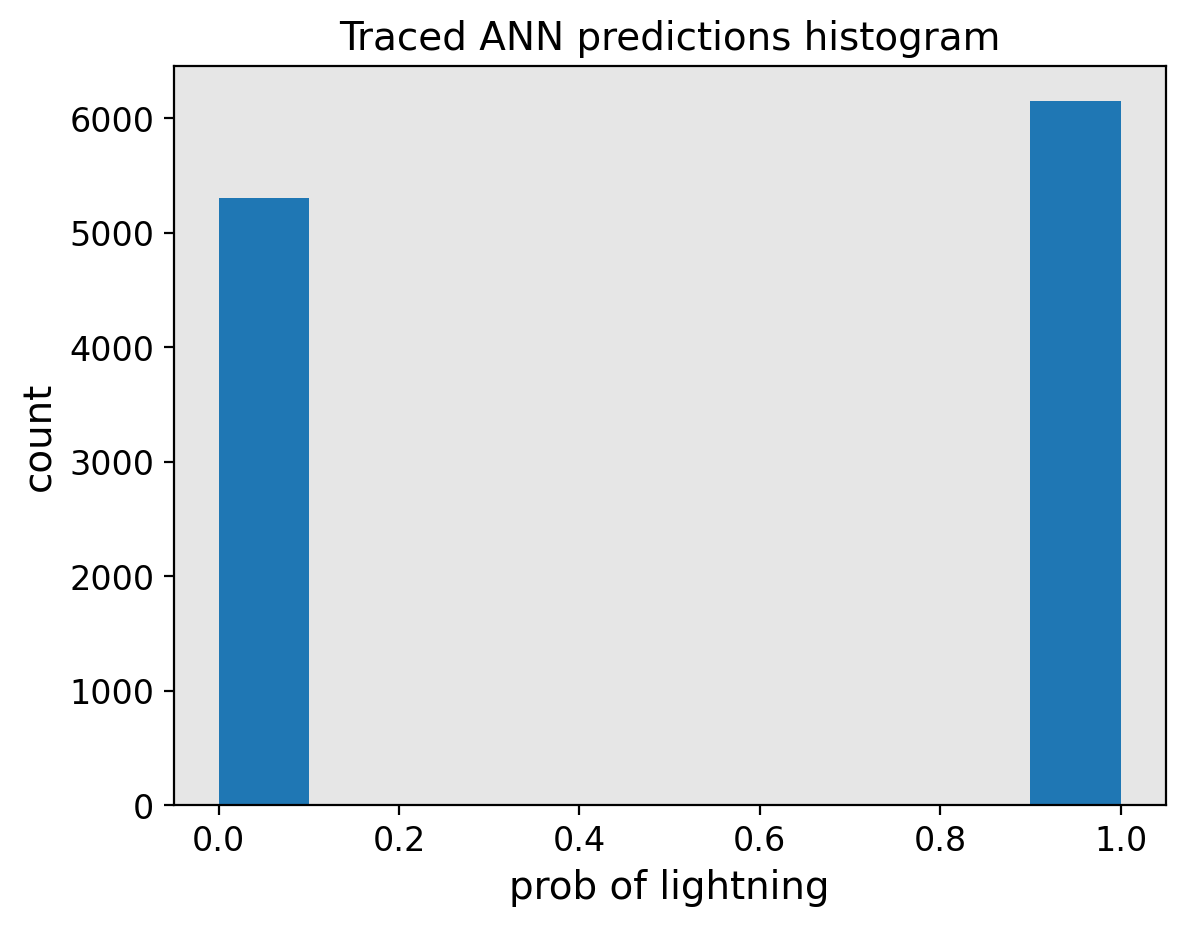

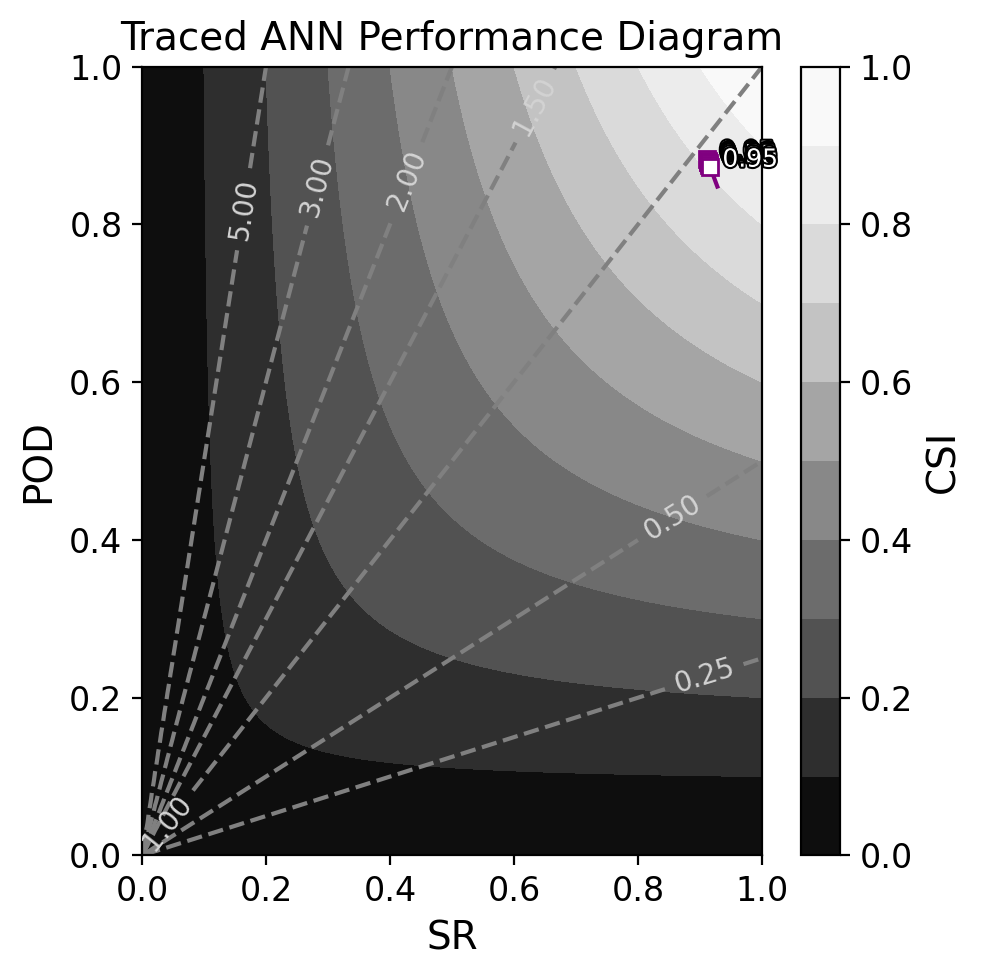

In [26]:
# Infer validation set with pretrained model
with torch.no_grad():
    # Make sure X_v_tensor is on the correct device if the model was traced on GPU
    y_preds_traced_tensor = pretrained_model(X_v_tensor)
    y_preds_traced = y_preds_traced_tensor.numpy()

# Plot histogram of predictions
plt.hist(y_preds_traced)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.title('Traced ANN predictions histogram')
plt.show()

# Recalculate metrics with trained predictions from the traced model
tps_traced, fps_traced, fns_traced = metric_calculator(torch.Tensor(y_v), y_preds_traced_tensor)
tps_traced, fps_traced, fns_traced = [x.numpy() for x in [tps_traced, fps_traced, fns_traced]]

# Calculate x,y for performance diagram
pods_traced = tps_traced / (tps_traced + fns_traced + eps)
srs_traced = tps_traced / (tps_traced + fps_traced + eps)

# Plot it up
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs_traced), np.asarray(pods_traced), '-', color='purple', markerfacecolor='w', label='Traced ANN')

for i, t in enumerate(thresh.numpy()):
    # Plot text and marker every 3rd point, because every point was too many
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.plot(np.asarray(srs_traced)[i], np.asarray(pods_traced)[i], 's', color='purple', markerfacecolor='w')
        ax.text(np.asarray(srs_traced)[i] + 0.02, np.asarray(pods_traced)[i], text, path_effects=pe1, fontsize=9, color='white')

plt.title('Traced ANN Performance Diagram')
plt.tight_layout()
plt.show()

Voila! Now you can hopefully do end-to-end neural networks. The next notebook will jump into convolutions.
